### Clustering sui giocatori

In [32]:
#import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
warnings.filterwarnings('ignore')

#PATH dove andare a leggere e a scrivere
PATH_TO_WRITE_ETL = "./dataset_modificato/"
PATH_FROM_READ_ETL = "./dataset_originale/"
PATH_FROM_READ_ANALYSIS = "./dataset_modificato/" 

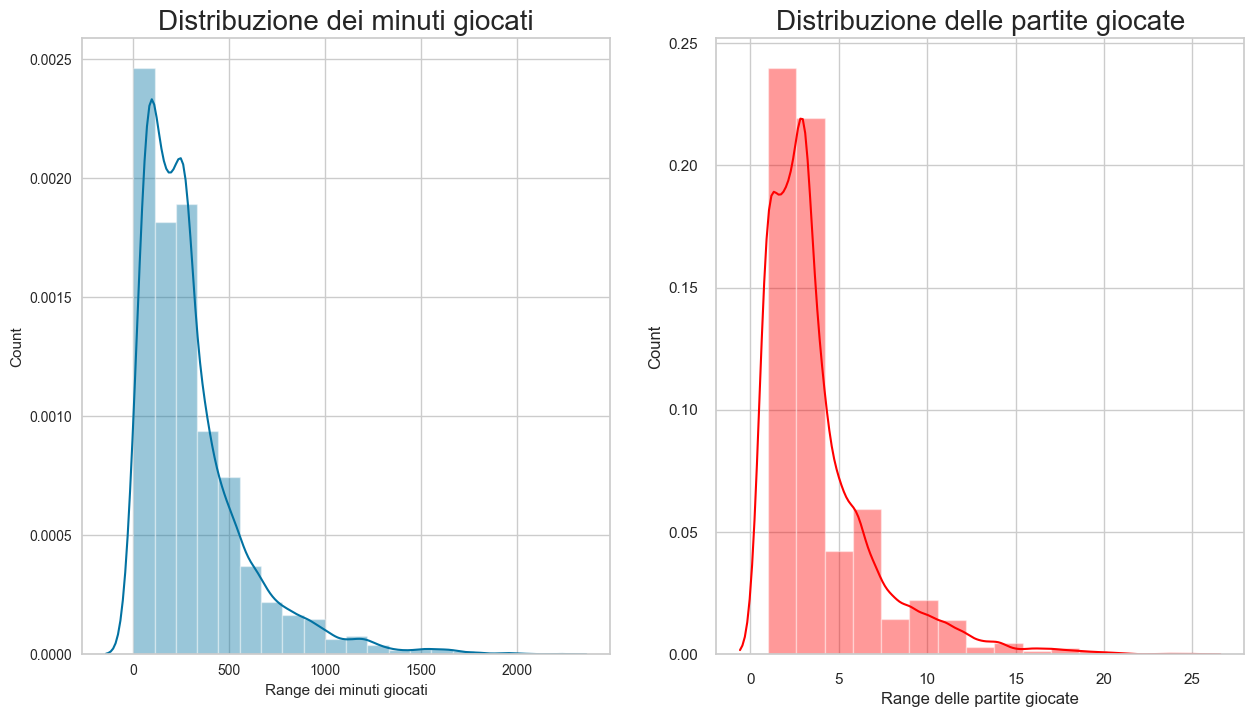

In [33]:
df_player_stats = pd.read_csv("./stats_players.csv")
#df_player_stats = df_player_stats[df_player_stats["n_minutes_played"]>0]
df_player_stats = df_player_stats[df_player_stats['n_minutes_played']>0]
df_player_stats['red_card'] = df_player_stats['second_yellow_card'] + df_player_stats['red_card']
df_player_stats = df_player_stats.drop(columns=['second_yellow_card'])
df_player_stats = df_player_stats.drop(columns=['total_own_goals'])
df_player_stats = df_player_stats.drop(columns=['yellow_card'])
df_player_stats = df_player_stats.drop(columns=['red_card'])

plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
sns.set(style = 'whitegrid')
sns.distplot(df_player_stats['n_minutes_played'], kde=True, bins=20)
plt.title('Distribuzione dei minuti giocati', fontsize = 20)
plt.xlabel('Range dei minuti giocati')
plt.ylabel('Count')


plt.subplot(1, 2, 2)
sns.set(style = 'whitegrid')
sns.distplot(df_player_stats['total_games_played'], color = 'red',kde=True, bins=15)
plt.title('Distribuzione delle partite giocate', fontsize = 20)
plt.xlabel('Range delle partite giocate')
plt.ylabel('Count')
plt.show()

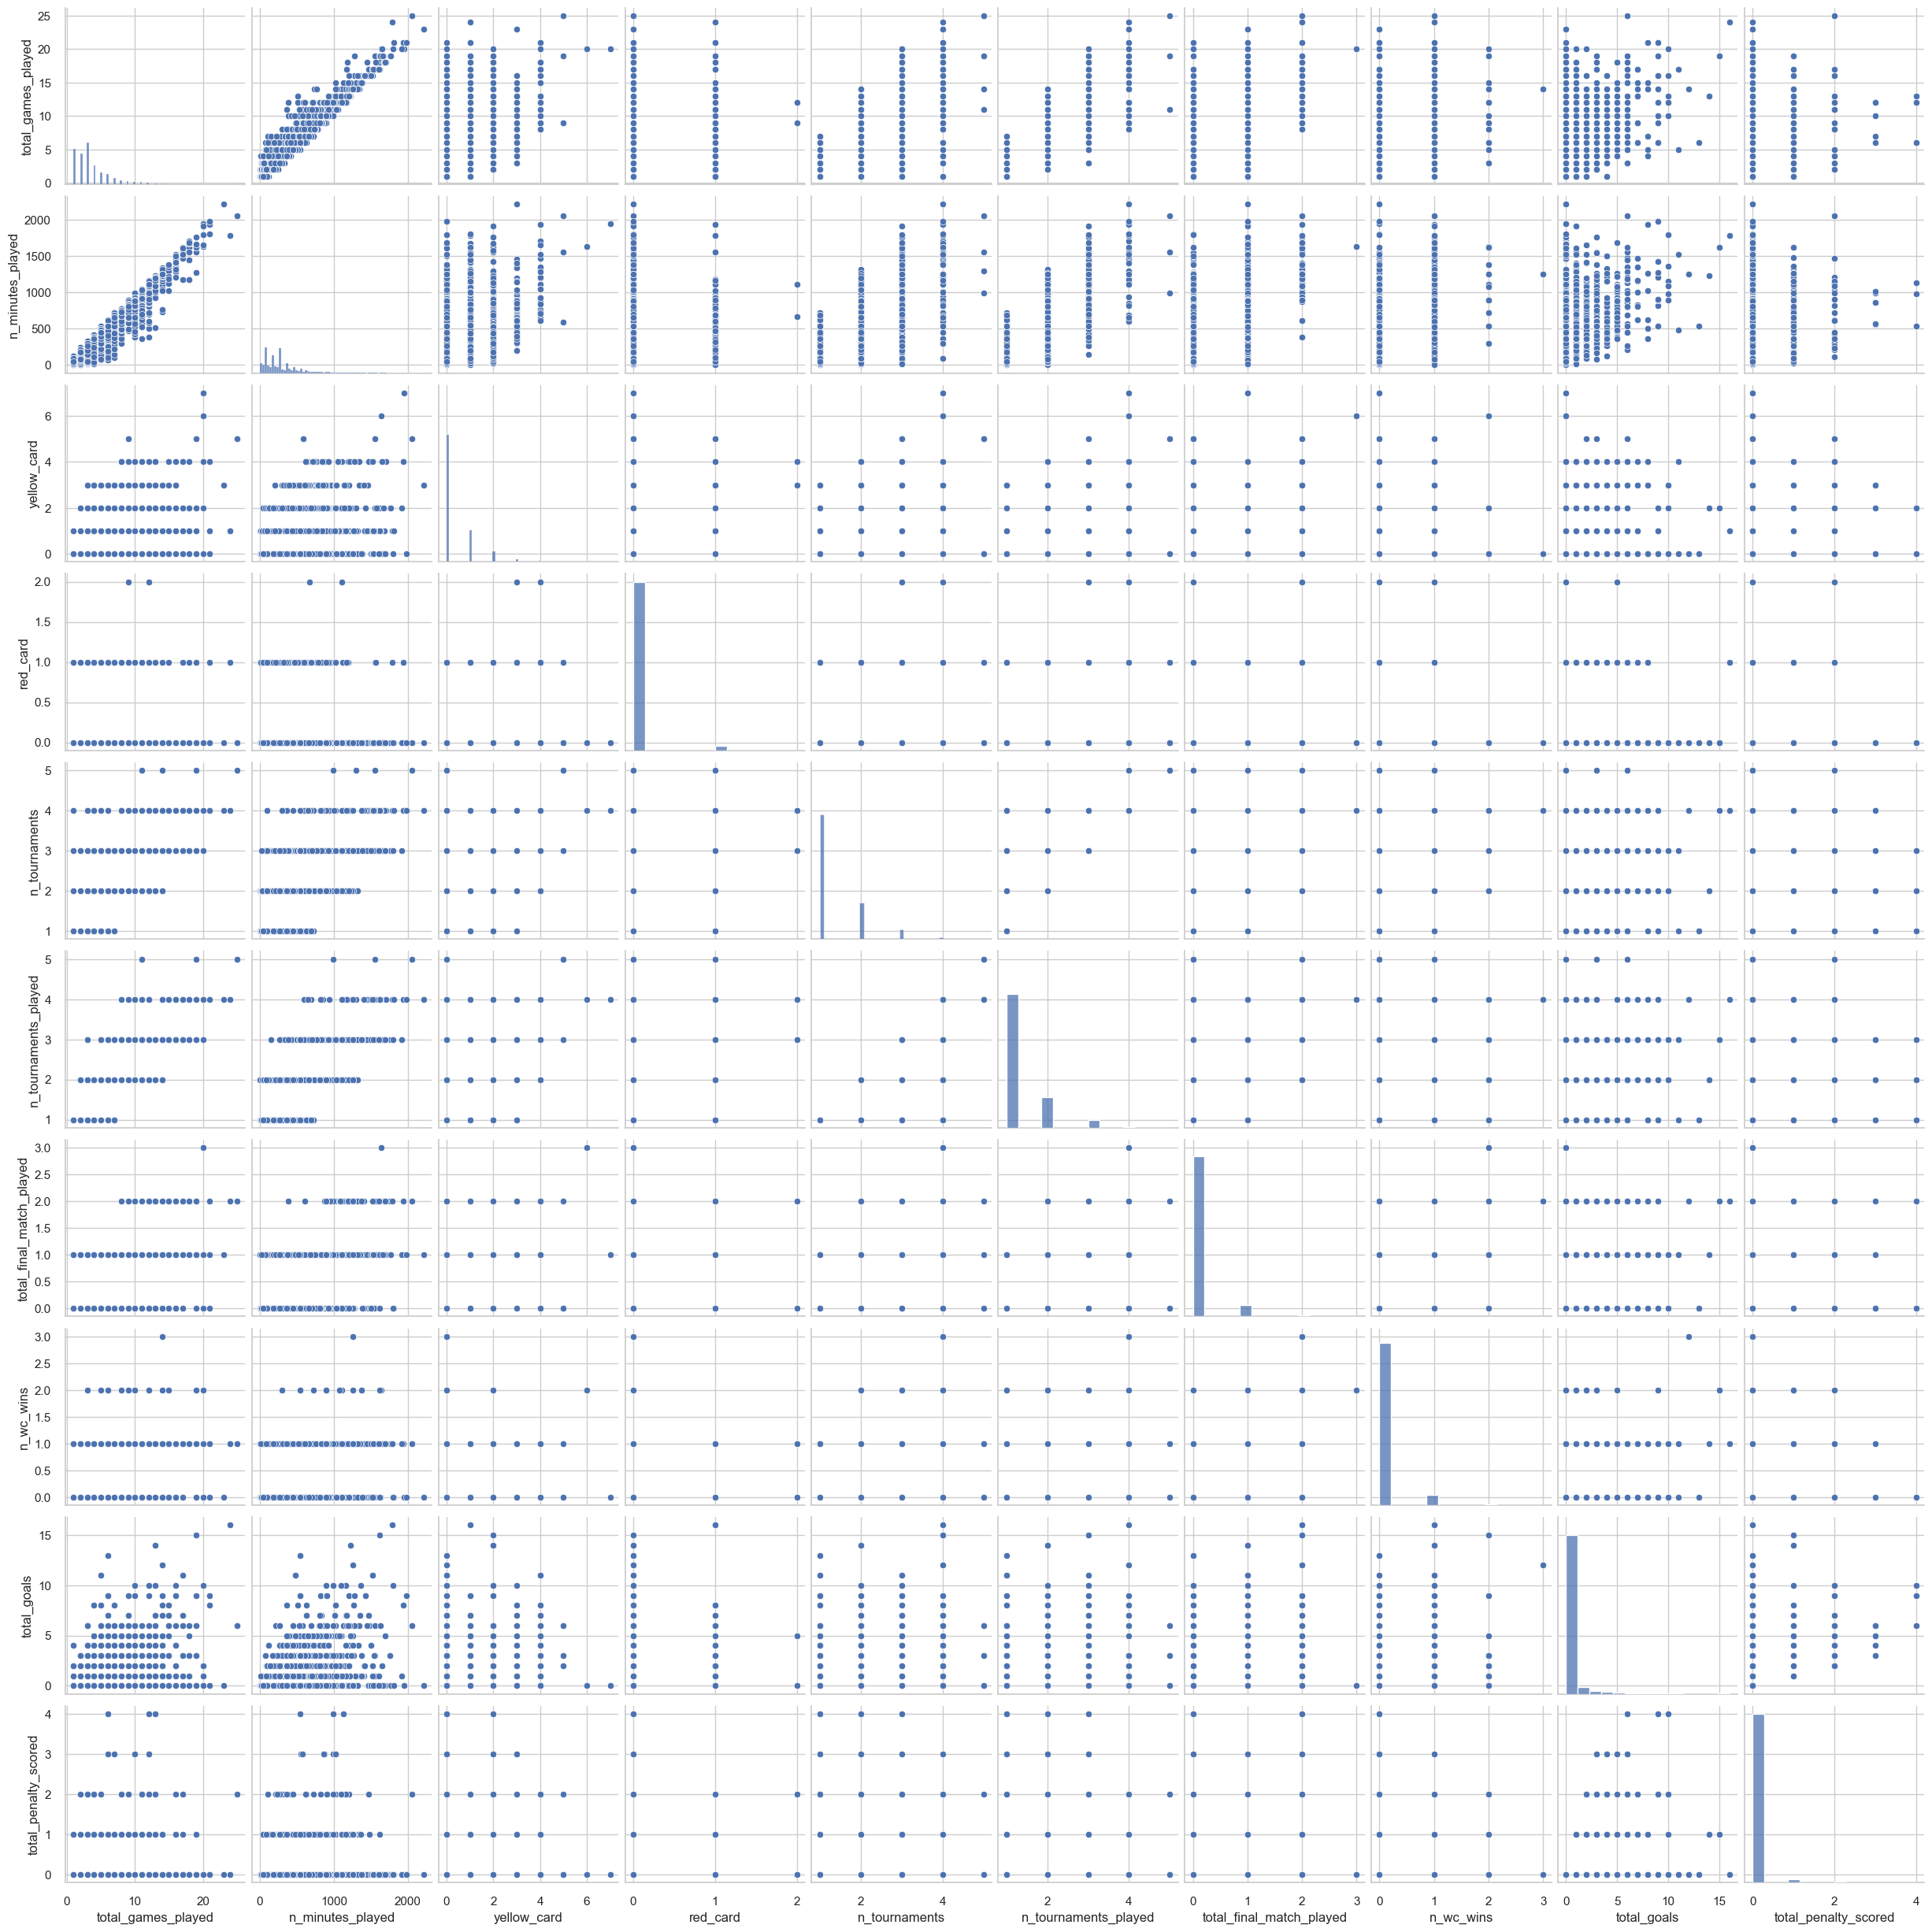

In [251]:
sns.pairplot(df_player_stats.drop(["player_id"], axis=1))

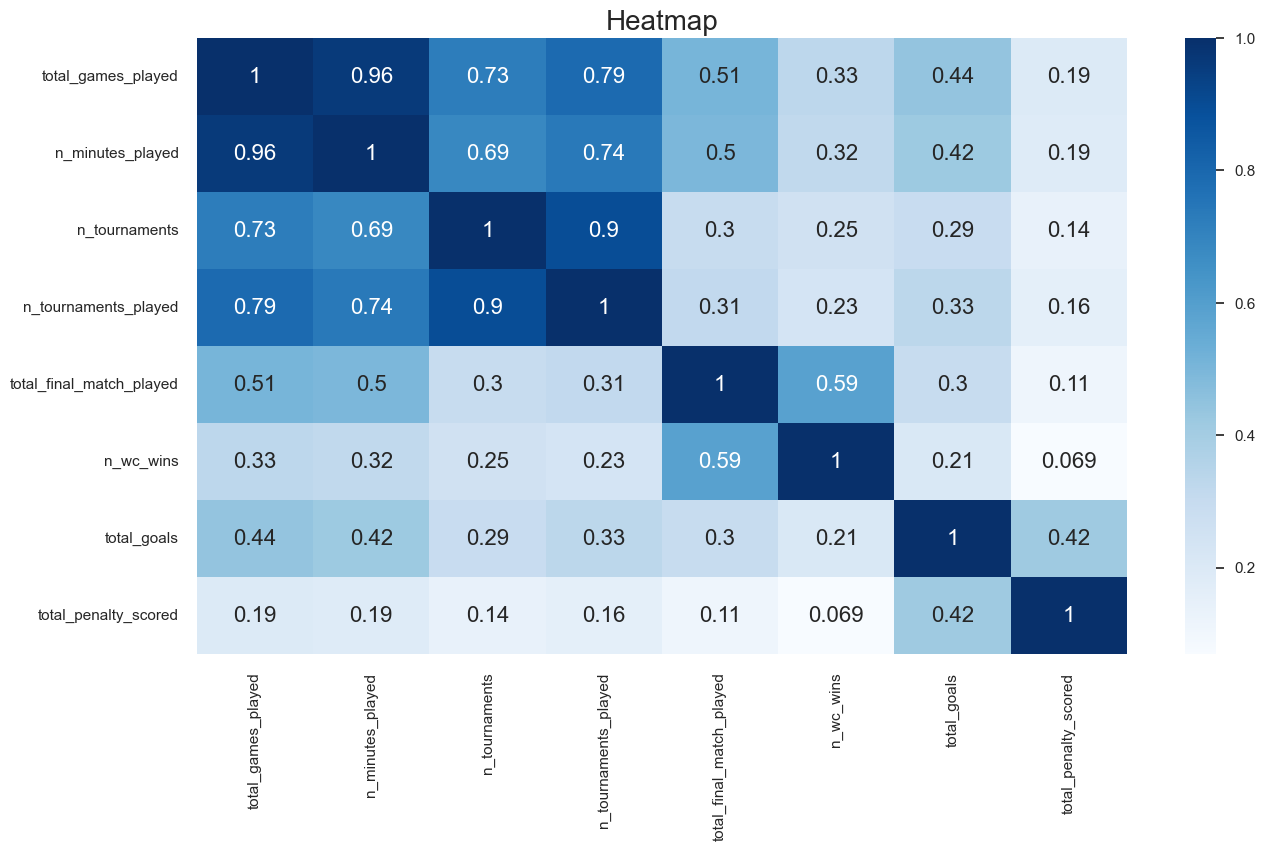

In [34]:
plt.figure(figsize=(15,8))
sns.heatmap(df_player_stats.drop(["player_id"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)
plt.show()

In [35]:
#normalizzazione
scaler = StandardScaler()
df_player_stats_std = scaler.fit_transform(df_player_stats.drop(["player_id"], axis=1))
print(np.mean(df_player_stats_std),np.std(df_player_stats_std))
print(df_player_stats_std.shape)

5.371399481506098e-17 1.0
(6085, 8)


Text(0, 0.5, 'Varianza comulativa')

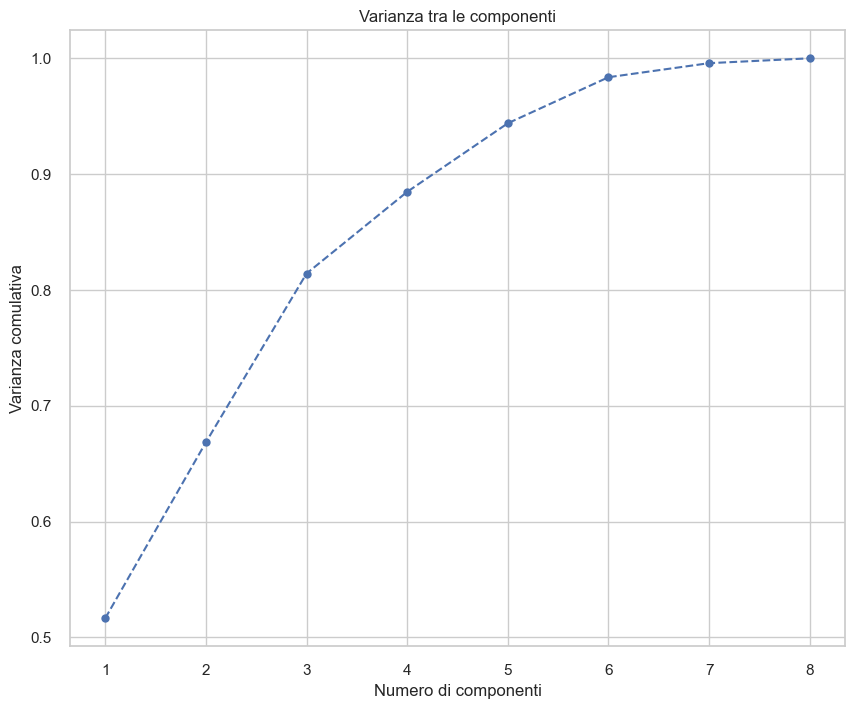

In [36]:
pca = PCA()
pca.fit(df_player_stats_std)
pca.explained_variance_ratio_

plt.figure(figsize=(10,8))
plt.plot(range(1,df_player_stats_std.shape[1]+1),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.title('Varianza tra le componenti')
plt.xlabel('Numero di componenti')
plt.ylabel('Varianza comulativa')

In [37]:
#prendiamo l'80% della varianza comulativa quindi 4 componenti
pca = PCA(n_components = 3, svd_solver='full')
pca.fit(df_player_stats_std)

PCA(n_components=3, svd_solver='full')

In [38]:
scores_pca = pca.transform(df_player_stats_std)
print(scores_pca.shape)

(6085, 3)


In [39]:
#Elbow Method
wcss = []
for i in range(1,50):
    kmeans_pca = KMeans(n_clusters=i,init='k-means++',random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

Text(0, 0.5, 'WCSS')

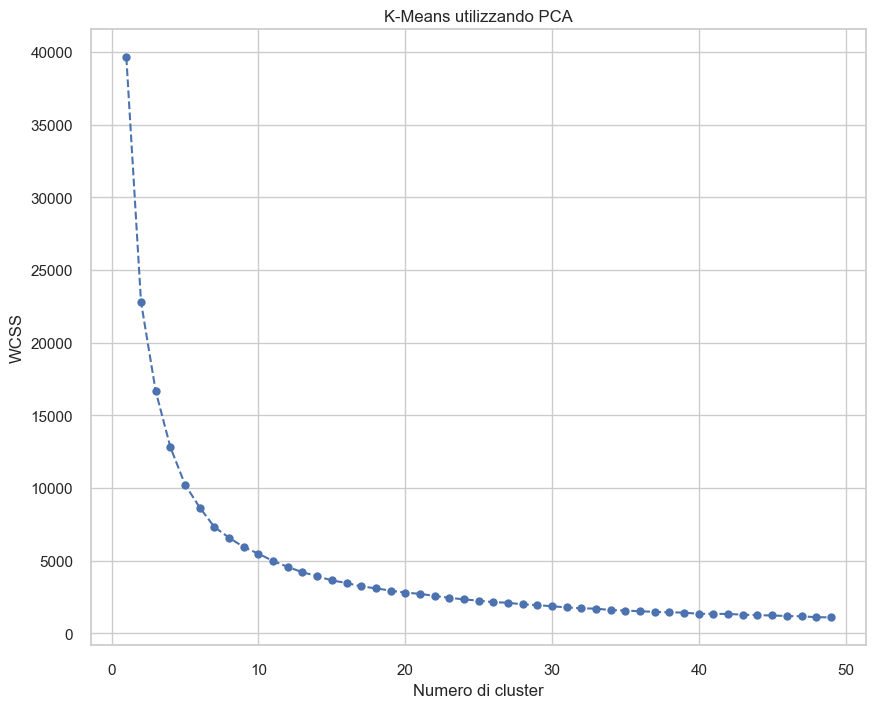

In [40]:

plt.figure(figsize=(10,8))
plt.plot(range(1,50),wcss,marker='o',linestyle='--')
plt.title('K-Means utilizzando PCA')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')

In [41]:
#numero di cluster
kl = KneeLocator(range(1,50),wcss,curve="convex",direction="decreasing")
print(kl.elbow)
kmeans_pca = KMeans(n_clusters=kl.elbow,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

7


KMeans(n_clusters=7, random_state=42)

In [42]:
#visualizzazione risultati
df_segm_pca_kmeans = pd.concat([df_player_stats.reset_index(drop=True),pd.DataFrame(scores_pca)],axis=1)
df_segm_pca_kmeans.columns.values[-3:] = ['C-1','C-2','C-3']
df_segm_pca_kmeans['Segm K-means PCA'] = kmeans_pca.labels_
df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segm K-means PCA'].map({0:'primo',1:'secondo',2:'terzo',
3:'quarto',4:'quinto',5:'sesto',6:'settimo'
})
#,8:'nono',9:'decimo'
df_segm_pca_kmeans.head()

,player_id,total_games_played,n_minutes_played,n_tournaments,n_tournaments_played,total_final_match_played,n_wc_wins,total_goals,total_penalty_scored,C-1,C-2,C-3,Segm K-means PCA,Segment
0,P-06163,20,1950,4,4,1,0,0,0,9.647707,-3.261832,-1.808256,1,secondo
1,P-08404,20,1639,4,4,3,2,0,0,12.964881,4.597754,-6.639769,1,secondo
2,P-02847,19,1554,5,5,0,0,3,0,9.942868,-5.165920,0.431409,2,terzo
3,P-02970,9,587,3,3,0,0,2,0,3.817236,-2.240679,0.471530,2,terzo
4,P-01993,25,2054,5,5,2,1,6,2,16.630496,3.049203,4.618529,6,settimo


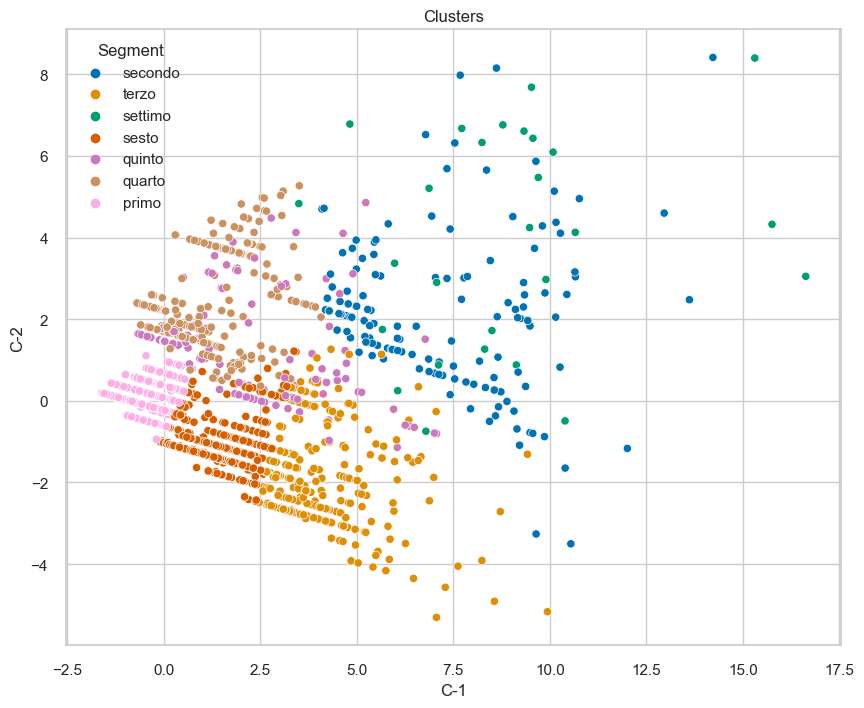

In [43]:
x_axis=df_segm_pca_kmeans['C-1']
y_axis=df_segm_pca_kmeans['C-2']
plt.figure(figsize=(10,8))
sns.scatterplot(x=x_axis,y=y_axis,hue=df_segm_pca_kmeans['Segment'],palette='colorblind')
plt.title('Clusters')
plt.show()

0.66


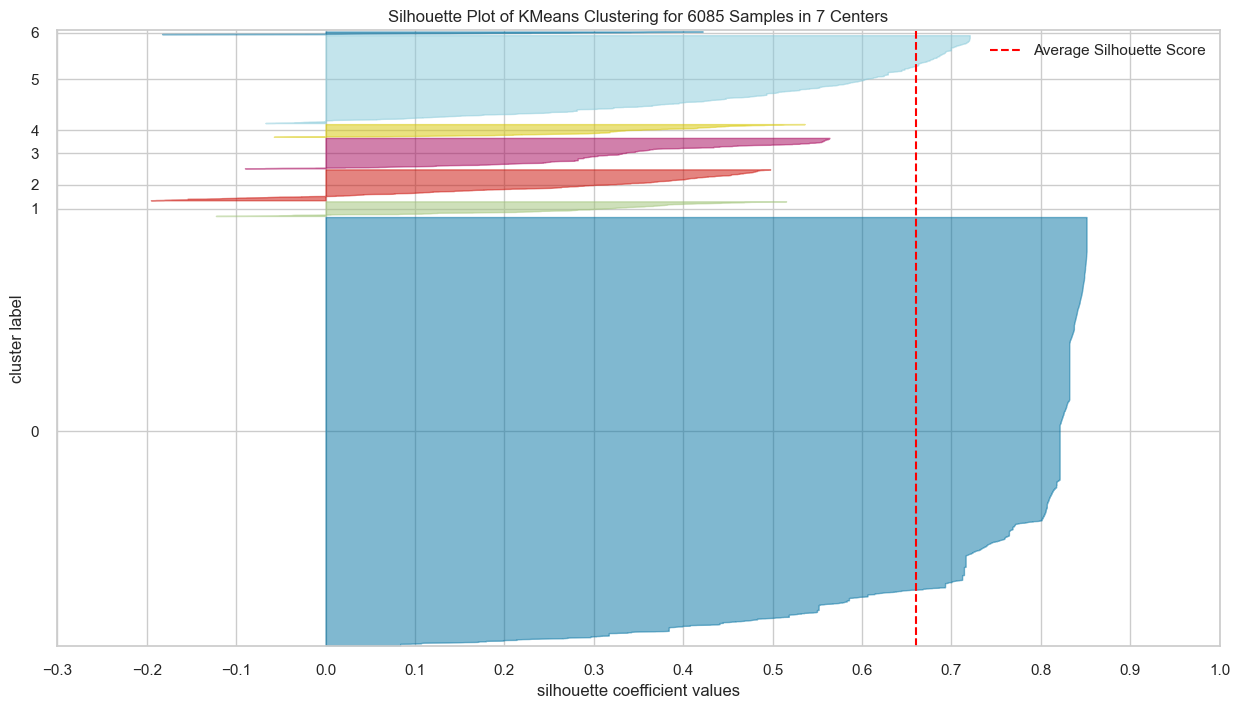

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 6085 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [45]:
kmeans_silhuouette = silhouette_score(scores_pca,kmeans_pca.labels_).round(2)
print(kmeans_silhuouette)
from yellowbrick.cluster import SilhouetteVisualizer


# Instantiate the clustering model and visualizer
model = KMeans(7, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

plt.figure(figsize=(15,8))
visualizer.fit(scores_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


In [46]:
df_players = pd.read_csv(PATH_FROM_READ_ANALYSIS+"players.csv")
df_segm_pca_kmeans_2 = df_players[["player_id","family_name","given_name"]].merge(df_segm_pca_kmeans,how="right",on="player_id")
df2 = pd.DataFrame()
#df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==0].describe()
for i in range(0,8):
    df = df_segm_pca_kmeans_2[df_segm_pca_kmeans_2["Segm K-means PCA"]==i]
    df.drop(["C-1","C-2","C-3"],axis=1,inplace=True)
    df.sort_values(by="n_minutes_played",ascending=False).to_csv("clusters/clusters_players/cluster_"+str(i)+".csv",index=False)
    df = df[["total_games_played","n_minutes_played","n_tournaments","n_tournaments_played","total_final_match_played","n_wc_wins","total_goals","total_penalty_scored"]]
    #,"yellow_card","red_card","total_own_goals"
    average = df.mean()
    average["group"] = i
    total = df.count()
    average.name = 'mean'
    df2 = df2.append(average)
df2


,total_games_played,n_minutes_played,n_tournaments,n_tournaments_played,total_final_match_played,n_wc_wins,total_goals,total_penalty_scored,group
mean,2.466418,188.456623,1.051539,1.000000,0.000000,0.000000,0.173274,0.000000,0.0
mean,13.238095,1136.455782,2.741497,2.632653,1.278912,1.000000,1.979592,0.061224,1.0
mean,10.180645,846.393548,2.809677,2.674194,0.177419,0.032258,1.070968,0.006452,2.0
mean,4.114754,330.672131,1.291803,1.134426,0.632787,0.695082,0.501639,0.003279,3.0
mean,5.718750,472.164062,1.570312,1.539062,0.078125,0.039062,2.906250,0.984375,4.0
mean,5.686364,448.715909,2.021591,1.909091,0.030682,0.001136,0.463636,0.000000,5.0
mean,13.111111,1106.185185,2.814815,2.703704,0.814815,0.481481,7.296296,2.185185,6.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0


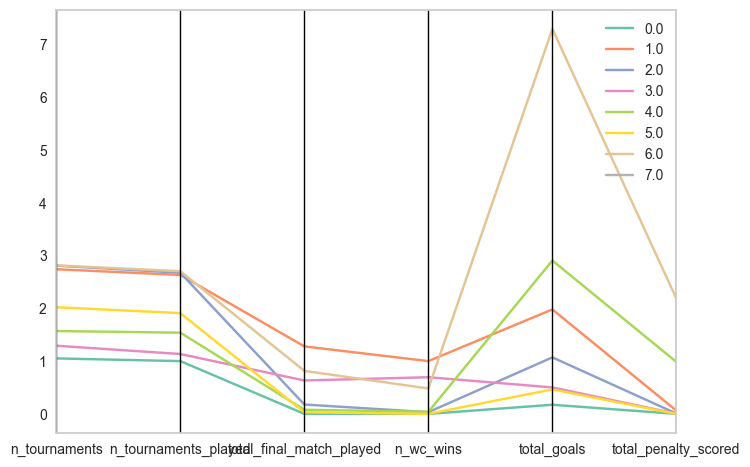

In [17]:
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '2'
parallel_coordinates(df2.drop(columns=["total_games_played","n_minutes_played"]),'group',colormap=plt.get_cmap("Set2"))

plt.show()


(6085, 3)


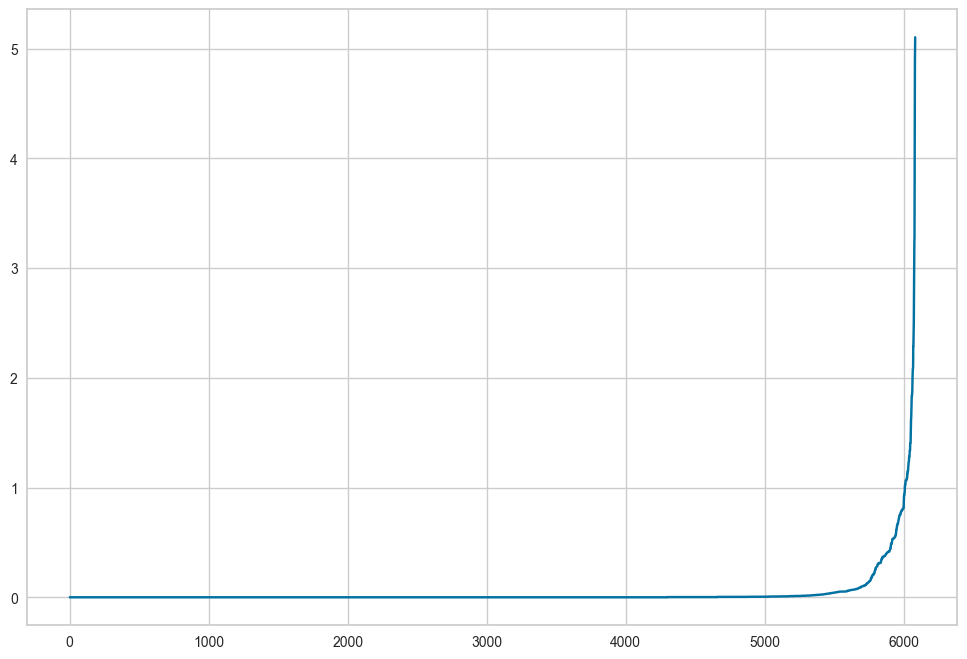

In [18]:
#DB-SCAN

from sklearn.neighbors import NearestNeighbors
import numpy as np

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(scores_pca)
distances, indices = nbrs.kneighbors(scores_pca)

distances = np.sort(distances, axis=0)
plt.figure(figsize=(12,8))
plt.plot(distances[:,1])
print(scores_pca.shape)

In [28]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1.1, min_samples=5).fit(scores_pca)
ymeans = db.labels_
print(set(ymeans))
df_segm_pca_dbScan= pd.concat([df_player_stats.reset_index(drop=True),pd.DataFrame(ymeans)],axis=1)
df_segm_pca_dbScan_2 = df_players[["player_id","family_name","given_name"]].merge(df_segm_pca_dbScan,how="right",on="player_id")
df2 = pd.DataFrame()
for i in range(-1,len(set(ymeans))-1):
    df = df_segm_pca_dbScan_2[df_segm_pca_dbScan_2[0]==i]
    df.sort_values(by="n_minutes_played",ascending=False).to_csv("clusters/cluster_players_dbscan/cluster_"+str(i)+".csv",index=False)
    df = df[["total_games_played","n_minutes_played","n_tournaments","n_tournaments_played","total_final_match_played","n_wc_wins","total_goals","total_penalty_scored"]]
    #,"yellow_card","red_card","total_own_goals"
    average = df.mean()
    total = df.count()
    average.name = 'mean'
    total.name = 'total'
    df2 = df2.append(average)
    df2 = df2.append(total)
dbscan_silhuouette = silhouette_score(scores_pca,db.labels_).round(2)
print(dbscan_silhuouette)
df2

#db = DBSCAN(eps=1.8, min_samples=5)
#visualizer = SilhouetteVisualizer(db, colors='yellowbrick',estimator=db)

#plt.figure(figsize=(15,8))
#visualizer.fit(scores_pca)        # Fit the data to the visualizer
#visualizer.show()     


{0, 1, 2, 3, 4, 5, -1}
0.51


,total_games_played,n_minutes_played,n_tournaments,n_tournaments_played,total_final_match_played,n_wc_wins,total_goals,total_penalty_scored
mean,12.592593,1070.935185,2.759259,2.629630,1.037037,0.712963,5.120370,0.787037
total,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,3.326997,259.979163,1.287333,1.223177,0.000000,0.000000,0.288613,0.016268
total,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000
mean,8.631016,727.925134,1.898396,1.802139,1.042781,0.957219,0.791444,0.005348
total,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,5.354730,430.540541,1.625000,1.456081,0.581081,0.418919,0.506757,0.000000
total,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,17.250000,1526.125000,3.000000,3.000000,2.000000,1.000000,0.875000,0.000000
total,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


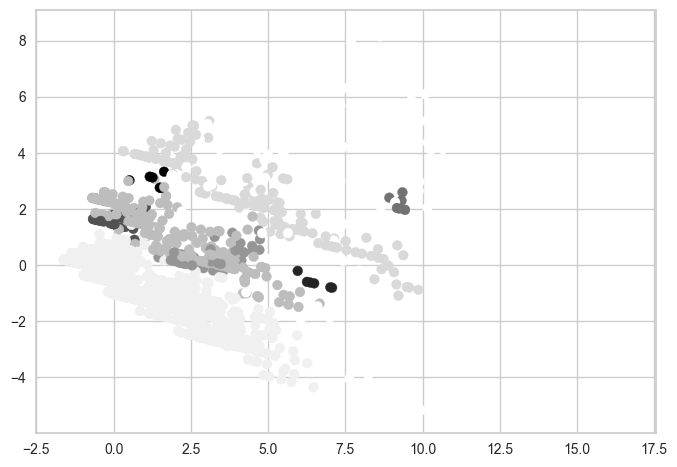

In [21]:
x_axis=df_segm_pca_kmeans['C-1']
y_axis=df_segm_pca_kmeans['C-2']
colors = db.labels_
plt.scatter(x_axis, y_axis, c = colors)

In [22]:
#Metodo per trovare eps
def get_metrics(eps, min_samples, dataset, iter_):
    
    # Fitting ======================================================================
    
    dbscan_model_ = DBSCAN( eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)
    
    # Mean Noise Point Distance metric =============================================
    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # Number of found Clusters metric ==============================================
    
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
    
    # Log ==========================================================================
    
    print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, str(noise_mean_distance), number_of_clusters))
        
    return(noise_mean_distance, number_of_clusters)

In [24]:
eps_to_test = [round(eps,1) for eps in np.arange(0.3, 1.5, 0.1)]
min_samples_to_test = range(5, 50, 5)

print("EPS:", eps_to_test)
print("MIN_SAMPLES:", list(min_samples_to_test))
# Dataframe per la metrica sulla distanza media dei noise points dai K punti più vicini
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

# Dataframe per la metrica sul numero di cluster
results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)
iter_ = 0

print("ITER| INFO%s |  DIST    CLUS" % (" "*39))
print("-"*65)

for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        
        iter_ += 1
        
        # Calcolo le metriche
        noise_metric, cluster_metric = get_metrics(eps, min_samples, scores_pca, iter_)
        
        # Inserisco i risultati nei relativi dataframe
        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric

EPS: [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4]
MIN_SAMPLES: [5, 10, 15, 20, 25, 30, 35, 40, 45]
ITER| INFO                                        |  DIST    CLUS
-----------------------------------------------------------------
  1 | Tested with eps = 0.3 and min_samples =   5 | 0.914   39
  2 | Tested with eps = 0.3 and min_samples =  10 | 0.696   23
  3 | Tested with eps = 0.3 and min_samples =  15 | 0.537   13
  4 | Tested with eps = 0.3 and min_samples =  20 | 0.501   11
  5 | Tested with eps = 0.3 and min_samples =  25 | 0.461    9
  6 | Tested with eps = 0.3 and min_samples =  30 | 0.431    7
  7 | Tested with eps = 0.3 and min_samples =  35 | 0.429    7
  8 | Tested with eps = 0.3 and min_samples =  40 | 0.409    7
  9 | Tested with eps = 0.3 and min_samples =  45 | 0.404    7
 10 | Tested with eps = 0.4 and min_samples =   5 | 1.068   32
 11 | Tested with eps = 0.4 and min_samples =  10 | 0.834   19
 12 | Tested with eps = 0.4 and min_samples =  15 | 0.669   

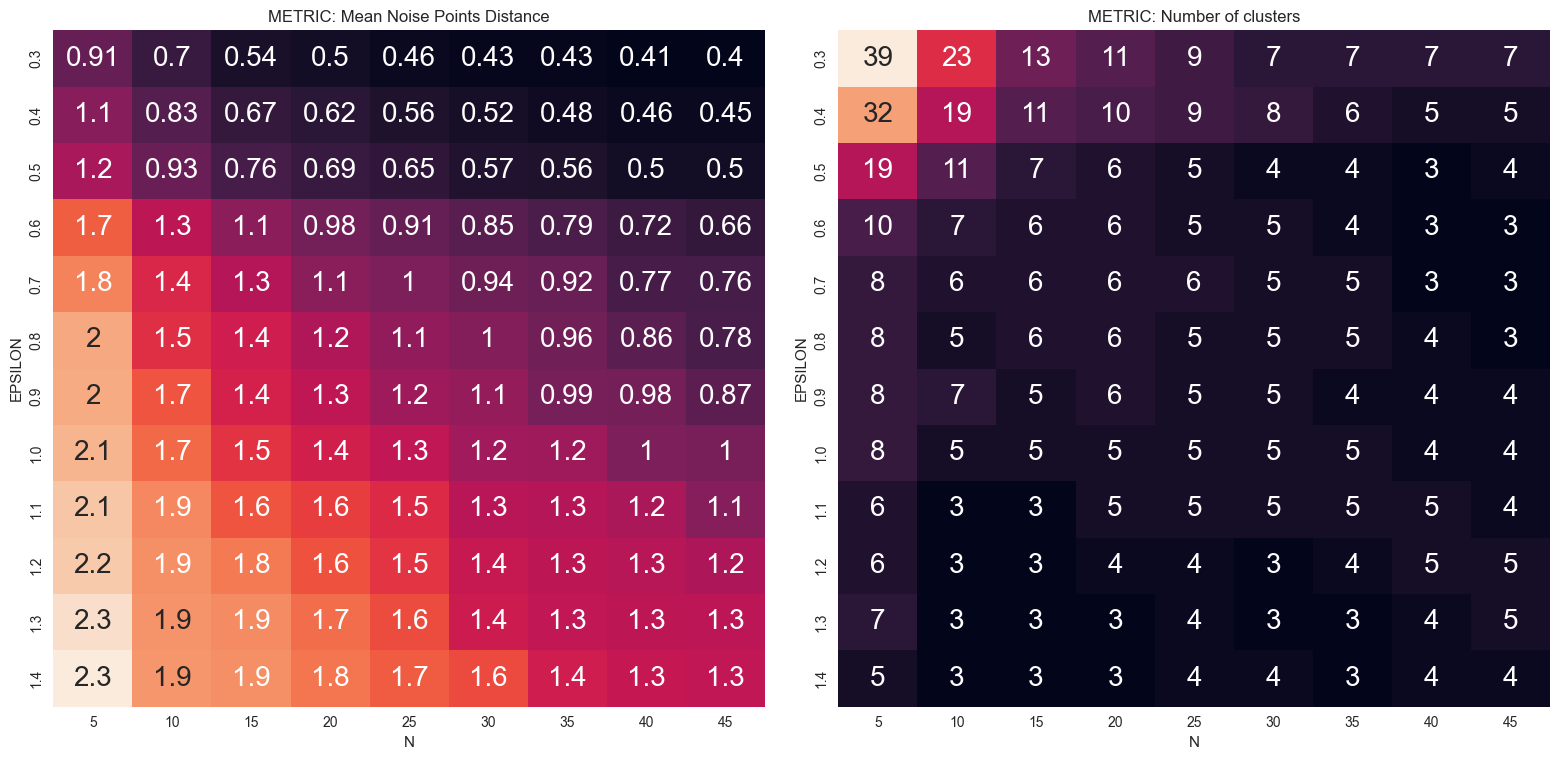

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8) )

sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("METRIC: Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("METRIC: Number of clusters")

ax1.set_xlabel("N"); ax2.set_xlabel("N")
ax1.set_ylabel("EPSILON"); ax2.set_ylabel("EPSILON")
plt.rcParams['font.size'] = '20'
plt.tight_layout(); plt.show()

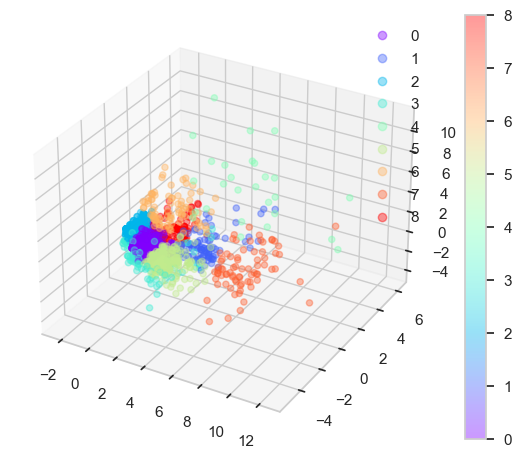

In [249]:
#print(df_segm_pca_kmeans[df_segm_pca_kmeans.player_id =="P-06516"])
#print(df_segm_pca_kmeans[df_segm_pca_kmeans.player_id =="P-03795"])

# Data for a three-dimensional line
z_axis = df_segm_pca_kmeans['C-3']
x_axis=df_segm_pca_kmeans['C-1']
y_axis=df_segm_pca_kmeans['C-2']
fig, ax = plt.subplots(subplot_kw=dict(projection="3d"))
c = np.tile(df_segm_pca_kmeans['Segm K-means PCA'],1)
sc = ax.scatter(x_axis, y_axis, z_axis, alpha=0.4, c=c, cmap='rainbow', s=20)
plt.legend(*sc.legend_elements())
plt.colorbar(sc)
plt.show()


In [125]:
#manager

df_manager_stats = pd.read_csv("./stats_managers.csv")
plt.figure(figsize=(15,8))
sns.heatmap(df_manager_stats.drop(["manager_id"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)
plt.show()

<IPython.core.display.Javascript object>